# Project: Automatic Fraud Detection - Lead Final Project #

## 1. EDA ##

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.io as pio
pio.kaleido.scope.plotlyjs = r'C:\Users\Public\plotly\package_data\plotly.min.js'
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import math
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import mlflow
from pickle import dump

pio.renderers.default = "png" # Comment / delete this line to show the figures in interactive format

In [2]:
data_fraud = pd.read_csv('../data/fraudTest.csv', index_col = "Unnamed: 0")
data_fraud.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [3]:
data_fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  555719 non-null  object 
 1   cc_num                 555719 non-null  int64  
 2   merchant               555719 non-null  object 
 3   category               555719 non-null  object 
 4   amt                    555719 non-null  float64
 5   first                  555719 non-null  object 
 6   last                   555719 non-null  object 
 7   gender                 555719 non-null  object 
 8   street                 555719 non-null  object 
 9   city                   555719 non-null  object 
 10  state                  555719 non-null  object 
 11  zip                    555719 non-null  int64  
 12  lat                    555719 non-null  float64
 13  long                   555719 non-null  float64
 14  city_pop               555719 non-nu

In [4]:
data_fraud['is_fraud'].value_counts(normalize = True)

0    0.99614
1    0.00386
Name: is_fraud, dtype: float64

There is 0.39 % fraud (553574 true transactions and 492 frauds).  
We have a very imbalanced dataset as the frauds account for 0.39% of all transactions.   
CAUTION on the metric to use: even a dummy model will find an accuracy score > 99%!

In [5]:
data_fraud.describe(include = 'all')

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,555719,5.557190e+05,555719,555719,555719.000000,555719,555719,555719,555719,555719,...,555719.000000,555719.000000,5.557190e+05,555719,555719,555719,5.557190e+05,555719.000000,555719.000000,555719.000000
unique,544760,NaN,693,14,NaN,341,471,2,924,849,...,NaN,NaN,NaN,478,910,555719,NaN,NaN,NaN,NaN
top,2020-12-19 16:02:22,NaN,fraud_Kilback LLC,gas_transport,NaN,Christopher,Smith,F,444 Robert Mews,Birmingham,...,NaN,NaN,NaN,Film/video editor,1977-03-23,2da90c7d74bd46a0caf3777415b3ebd3,NaN,NaN,NaN,NaN
freq,4,NaN,1859,56370,NaN,11443,12146,304886,1474,2423,...,NaN,NaN,NaN,4119,2408,1,NaN,NaN,NaN,NaN
mean,NaN,4.178387e+17,NaN,NaN,69.392810,NaN,NaN,NaN,NaN,NaN,...,38.543253,-90.231325,8.822189e+04,NaN,NaN,NaN,1.380679e+09,38.542798,-90.231380,0.003860
std,NaN,1.309837e+18,NaN,NaN,156.745941,NaN,NaN,NaN,NaN,NaN,...,5.061336,13.721780,3.003909e+05,NaN,NaN,NaN,5.201104e+06,5.095829,13.733071,0.062008
min,NaN,6.041621e+10,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,20.027100,-165.672300,2.300000e+01,NaN,NaN,NaN,1.371817e+09,19.027422,-166.671575,0.000000
25%,NaN,1.800429e+14,NaN,NaN,9.630000,NaN,NaN,NaN,NaN,NaN,...,34.668900,-96.798000,7.410000e+02,NaN,NaN,NaN,1.376029e+09,34.755302,-96.905129,0.000000
50%,NaN,3.521417e+15,NaN,NaN,47.290000,NaN,NaN,NaN,NaN,NaN,...,39.371600,-87.476900,2.408000e+03,NaN,NaN,NaN,1.380762e+09,39.376593,-87.445204,0.000000
75%,NaN,4.635331e+15,NaN,NaN,83.010000,NaN,NaN,NaN,NaN,NaN,...,41.894800,-80.175200,1.968500e+04,NaN,NaN,NaN,1.385867e+09,41.954163,-80.264637,0.000000


Notes:
- For this specific problem, there is no need to try to remove the outliers: these are the ones we are trying to detect.
- The data being strongly unbalanced, do not forget the "stratify" option when separating into train / test.
- Selection of variables and data engineering
    - Calculation of the distance between lat/long buyer and lat/long seller,
    - Convert date of purchase to day, month, year, and day of week,
    - Creation of the age column according to the date of birth,
    - Conversion of gender (F / M) to binary value (1 / 0),
    - Removal of columns deemed uninteresting.

In [6]:
# Convert 'Date' column to date time
data_fraud['Date'] = pd.to_datetime(data_fraud['trans_date_trans_time'])

In [7]:
# Create new columns
data_fraud['day'] = data_fraud['Date'].dt.day
data_fraud['month'] = data_fraud['Date'].dt.month
data_fraud['year'] = data_fraud['Date'].dt.year
data_fraud['weekday'] = data_fraud['Date'].dt.weekday

In [8]:
# Convert gender column to binary values
data_fraud['gender'] = data_fraud['gender'].apply(lambda x: 1 if x =='F' else 0)

In [9]:
# Calculate age 
data_fraud['age'] = pd.to_datetime(data_fraud['dob'])
today = datetime.now()
data_fraud['age'] = ((today - data_fraud['age']) / pd.Timedelta(days=365.25)).astype(int)

In [10]:
# Calculate distance between buyer and seller
def haversine(lon_1, lon_2, lat_1, lat_2):
    
    lon_1, lon_2, lat_1, lat_2 = map(np.radians, [lon_1, lon_2, lat_1, lat_2])  # Convert degrees to Radians
    
    
    diff_lon = lon_2 - lon_1
    diff_lat = lat_2 - lat_1
    

    distance_km = 2*6371*np.arcsin(np.sqrt(np.sin(diff_lat/2.0)**2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(diff_lon/2.0)**2)) # earth radius: 6371km
    
    return distance_km

data_fraud['transaction_distance'] = data_fraud.apply(lambda x: haversine(x.long, x.merch_long, x.lat, x.merch_lat), axis=1)

In [11]:
data_fraud.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,merch_lat,merch_long,is_fraud,Date,day,month,year,weekday,age,transaction_distance
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,0,351 Darlene Green,Columbia,...,33.986391,-81.200714,0,2020-06-21 12:14:25,21,6,2020,6,55,24.561462
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,1,3638 Marsh Union,Altonah,...,39.450498,-109.960431,0,2020-06-21 12:14:33,21,6,2020,6,33,104.925092
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,1,9333 Valentine Point,Bellmore,...,40.495810,-74.196111,0,2020-06-21 12:14:53,21,6,2020,6,52,59.080078
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,0,32941 Krystal Mill Apt. 552,Titusville,...,28.812398,-80.883061,0,2020-06-21 12:15:15,21,6,2020,6,36,27.698567
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,0,5783 Evan Roads Apt. 465,Falmouth,...,44.959148,-85.884734,0,2020-06-21 12:15:17,21,6,2020,6,68,104.335106


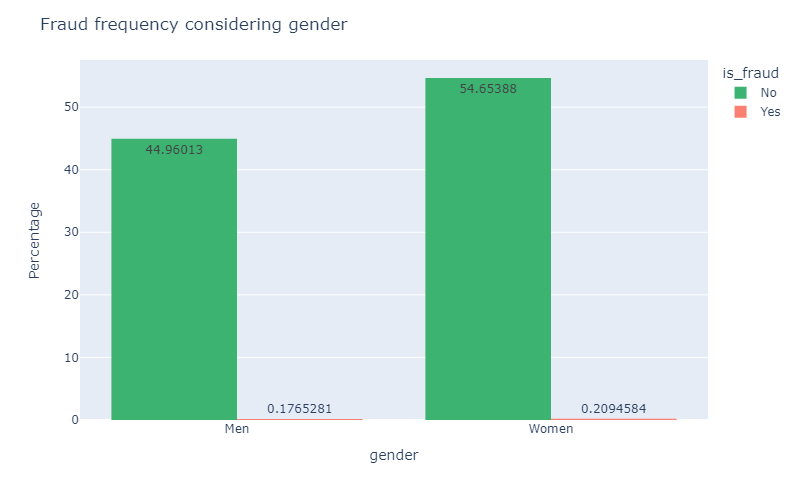

In [13]:
# Histogram of Fraud / Non fraud by Gender
df_gender = pd.DataFrame(data_fraud.groupby(["gender","is_fraud"])["is_fraud"].count()/len(data_fraud)*100)
df_gender["percentage"] = df_gender["is_fraud"]
df_gender = df_gender.drop(columns = ["is_fraud"])
df_gender = df_gender.reset_index(level = ["gender", "is_fraud"])
df_gender["gender"] = df_gender["gender"].apply(lambda x: "Women" if x == 1 else "Men")
df_gender["is_fraud"] = df_gender["is_fraud"].apply(lambda x: "No" if x == 0 else "Yes")

fig_gender = px.histogram(df_gender, x = "gender", y = "percentage",
                color = "is_fraud", barmode = "group",
                text_auto = True,
                color_discrete_sequence = ["mediumseagreen", "salmon"])

fig_gender.update_layout(title_text = "Fraud frequency considering gender",
                  yaxis_title = "Percentage", width = 800)

fig_gender.show()

According to the distribution observed above, the dataset contains more transactions carried out by women (~10%), which does not seem incompatible with the habits of the current world.  
However, if we look at the transactions carried out by men or by women, the frequency of detected fraudulent transactions is similar (~0.4% in both cases).

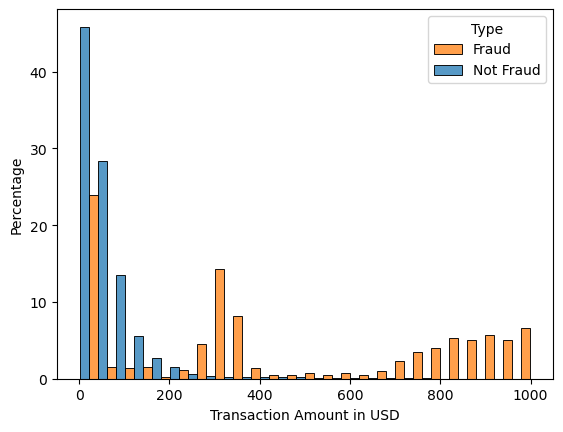

In [14]:
# Fraud/non-fraud percentage histogram by spending range
fig_spending = sns.histplot(x = 'amt', data = data_fraud[data_fraud.amt<=1000], hue = 'is_fraud', stat = 'percent', multiple = 'dodge', common_norm = False, bins = 25)
fig_spending.set_ylabel('Percentage')
fig_spending.set_xlabel('Transaction Amount in USD')
plt.legend(title = 'Type', labels = ['Fraud', 'Not Fraud'])

As shown above, normal transactions tend to be around $200 or less, while fraudulent transactions have a peak arount $300 and then at the $800 - $1000 range.

Text(0.5, 1.0, 'The Percentage Difference of Fraudulent over \nNon-Fraudulent Transations in Each Spending Category\n')

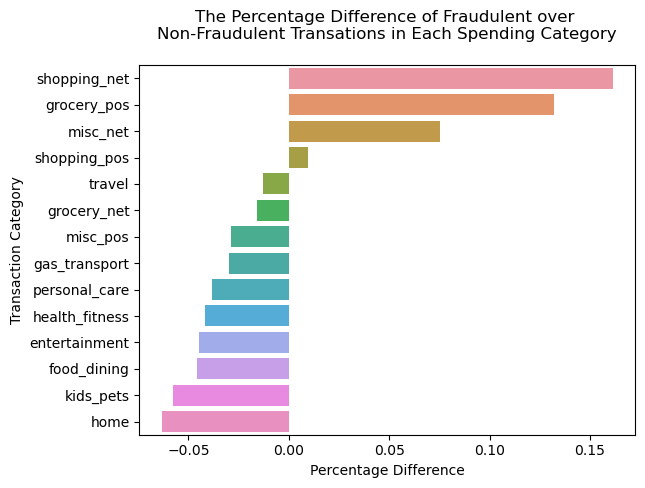

In [15]:
# The percentage difference of fraudulent over non-fraudulent transactions in each spending category
a = data_fraud[data_fraud['is_fraud'] == 0]['category'].value_counts(normalize = True).to_frame().reset_index()
a.columns = ['category','not fraud percentage']

b = data_fraud[data_fraud['is_fraud'] == 1]['category'].value_counts(normalize = True).to_frame().reset_index()
b.columns = ['category','fraud percentage']

ab = a.merge(b, on = 'category')
ab['diff'] = ab['fraud percentage'] - ab['not fraud percentage']

fig_category = sns.barplot(y = 'category', x = 'diff', data = ab.sort_values('diff', ascending = False))
fig_category.set_xlabel('Percentage Difference')
fig_category.set_ylabel('Transaction Category')
plt.title('The Percentage Difference of Fraudulent over \nNon-Fraudulent Transations in Each Spending Category\n')

Some spending categories show more fraud than other.  
In fact, fraud tends to happen more often in "Shopping_net", "Grocery_pos", and "misc_net" categories.  
These categories are more common and by the way, more difficult to detect in normal people bills.

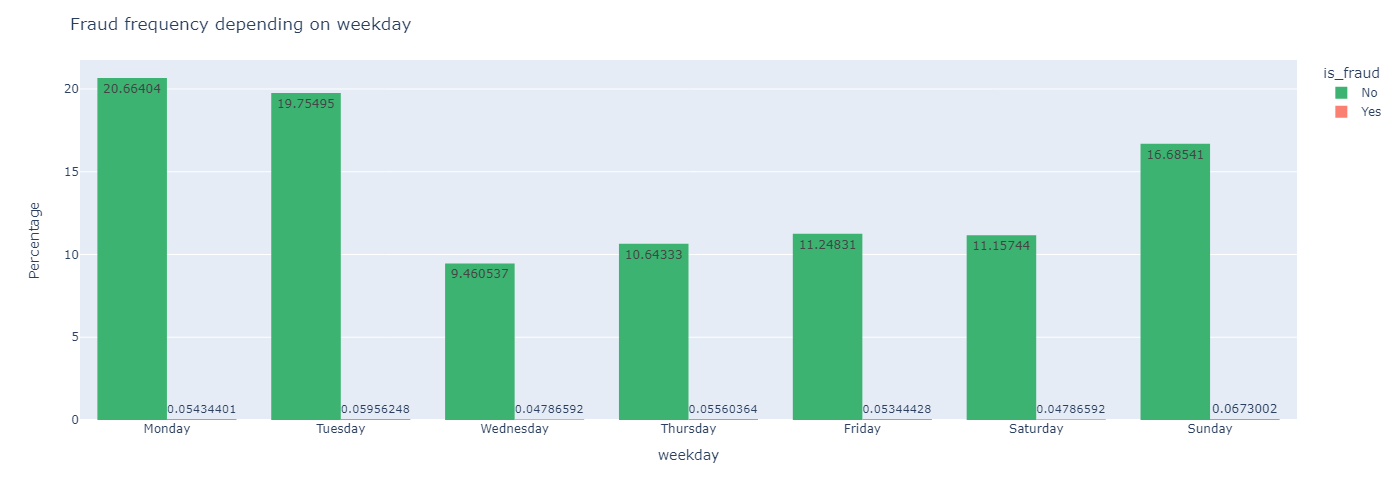

In [17]:
# Evolution of the percentage of fraud according to the day of the week
df_weekday = pd.DataFrame(data_fraud.groupby(["weekday","is_fraud"])["is_fraud"].count()/len(data_fraud)*100)
df_weekday["percentage"] = df_weekday["is_fraud"]
df_weekday = df_weekday.drop(columns = ["is_fraud"])
df_weekday = df_weekday.reset_index(level = ["weekday", "is_fraud"])
df_weekday["weekday"] = df_weekday["weekday"].apply(lambda x: "Monday" if x == 0 else "Tuesday" if x == 1 else "Wednesday" if x == 2 else "Thursday" if x == 3 else "Friday" if x == 4 else "Saturday" if x == 5 else "Sunday")
df_weekday["is_fraud"] = df_weekday["is_fraud"].apply(lambda x: "No" if x == 0 else "Yes")

fig_weekday = px.histogram(df_weekday, x = "weekday", y = "percentage",
                color = "is_fraud", barmode = "group",
                text_auto = True,
                color_discrete_sequence = ["mediumseagreen", "salmon"])

fig_weekday.update_layout(title_text = "Fraud frequency depending on weekday",
                  yaxis_title = "Percentage", width = 1400)

fig_weekday.show()

The majority of payments made by people seem to take place on Mondays, Tuesdays, as well as Sundays.  
Conversely, the days that seem most affected by fraudulent payments are Wednesday and Thursday (~0.55%), as well as Friday and Saturday (~0.45%).

C:\Users\Ophélie\AppData\Local\Temp\ipykernel_16328\2121617881.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



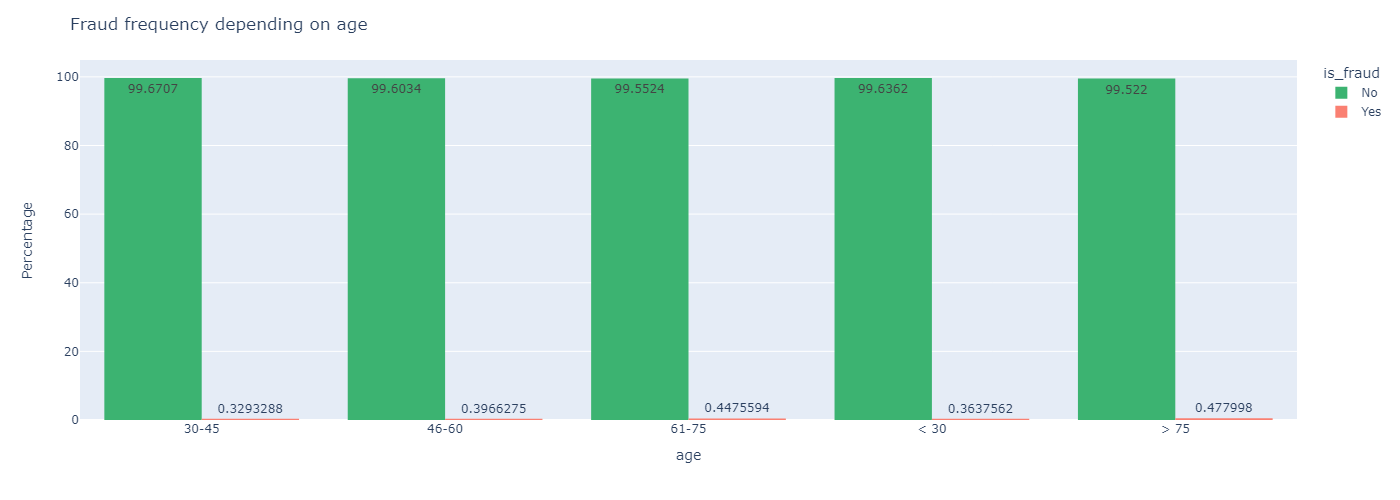

In [18]:
# Fraud / Non fraud based on age range
df_tmp = pd.DataFrame()
df_tmp[["age_range", "trans_num", "is_fraud"]] = data_fraud[["age", "trans_num", "is_fraud"]]

# Convert specific age to a range
for i in range(len(data_fraud.age)):
  if data_fraud.age[i] <= 30:
    df_tmp["age_range"][i] = '< 30'
  elif data_fraud.age[i] > 30 and data_fraud.age[i] <= 45:
    df_tmp["age_range"][i] = '30-45'
  elif data_fraud.age[i] > 45 and data_fraud.age[i] <= 60:
    df_tmp["age_range"][i] = '46-60'
  elif data_fraud.age[i] > 60 and data_fraud.age[i] <= 75:
    df_tmp["age_range"][i] = '61-75'
  else:
    df_tmp["age_range"][i] = '> 75'

# Create the age-transaction count table
df_age = df_tmp[['age_range','trans_num']].groupby(['age_range']).count().reset_index()
df_age.columns = ['age', 'age_count']
df_age

# Create the age-fraude count table
df_fraud_age = df_tmp[['age_range', 'trans_num', 'is_fraud']].groupby(['age_range','is_fraud']).count().reset_index()
df_fraud_age.columns = ['age', 'is_fraud', 'transaction_count']

# Compile both tables
df_fraud_age = df_fraud_age.merge(df_age[['age', 'age_count']], how='inner', on='age')

# Calculate the percentage of fraudulent payment per age range
df_fraud_age['transaction_percentage'] = (df_fraud_age['transaction_count']/df_fraud_age['age_count'])*100

# Convert 0/1 for fraud to No/Yes
df_fraud_age["is_fraud"] = df_fraud_age["is_fraud"].apply(lambda x: "No" if x == 0 else "Yes")

# Draw figure
fig_age = px.histogram(df_fraud_age, x = "age", y = "transaction_percentage",
                color = "is_fraud", barmode = "group",
                text_auto = True,
                color_discrete_sequence = ["mediumseagreen", "salmon"])

fig_age.update_layout(title_text = "Fraud frequency depending on age",
                  yaxis_title = "Percentage", width = 1400)

fig_age.show()

In [19]:
# Drop unnecessary columns
c = ['trans_date_trans_time', 'Date','cc_num', 'first', 'last', 'street', 'city', 'zip', 'state', 'job', 'dob', 'trans_num']
data_fraud = data_fraud.drop(columns = c)

## 2. Data pre-processing ##

In [21]:
X = data_fraud.drop('is_fraud', axis = 1)
Y = data_fraud['is_fraud']

# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.items():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['amt', 'gender', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long', 'day', 'month', 'year', 'weekday', 'age', 'transaction_distance']
Found categorical features  ['merchant', 'category']


In [33]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 0)
print("...Done.")

Dividing into train and test sets...
...Done.


In [34]:
# Create pipeline for numeric features
numeric_transformer = StandardScaler() # Need to standardize features because we'll first use a linear regression as baseline model
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print()

dump(preprocessor, open('preprocessor.pkl', 'wb'))

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')

Performing preprocessings on train set...
...Done.

Performing preprocessings on test set...
...Done.


# Baseline : logistic Regression

In [30]:
# Set your variables for your environment
EXPERIMENT_NAME="fraud-detection"

# Set tracking URI to your Heroku application
# mlflow.set_tracking_uri(os.environ["APP_URI"])
mlflow.set_tracking_uri("https://mlflow-server-b1e1f87ddda8.herokuapp.com/")

# Set experiment's info 
mlflow.set_experiment(EXPERIMENT_NAME)

# Get our experiment info
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

2023/07/18 17:13:04 INFO mlflow.tracking.fluent: Experiment with name 'fraud-detection' does not exist. Creating a new experiment.


In [33]:
# Call mlflow autolog
mlflow.sklearn.autolog()

mlflow.end_run()

with mlflow.start_run(experiment_id = experiment.experiment_id):
   
    mlflow.set_tag("user", "Ophélie")
    mlflow.set_tag("model", "logistic regression")
    mlflow.set_tag("description", "lr")

    # Train model
    print("Train model...")
    lr = LogisticRegression()
    lr.fit(X_train, Y_train)
    print("...Done.")

    print("score on training set : ", lr.score(X_train, Y_train))
    print("score on test set : ", lr.score(X_test, Y_test))

Train model...


2023/07/18 17:14:30 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
/Users/dl/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
2023/07/18 17:14:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/dl/anaconda3/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


...Done.
score on training set :  0.9958657144463814
score on test set :  0.9959062117613187


In [34]:
# Call mlflow autolog
mlflow.sklearn.autolog()

mlflow.end_run()

with mlflow.start_run(experiment_id = experiment.experiment_id):
   
    mlflow.set_tag("user", "Ophélie")
    mlflow.set_tag("model", "random forest classifier")
    mlflow.set_tag("description", "rfc")

    # Train model
    print("Random Forest with default hyperparameters...")
    rfc = RandomForestClassifier() # we must use a regressor here!
    rfc.fit(X_train, Y_train)
    print("...Done.")
    
    # Print scores
    print("score on training set : ", rfc.score(X_train, Y_train))
    print("score on test set : ", rfc.score(X_test, Y_test))

Random Forest with default hyperparameters...


2023/07/18 17:17:09 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


...Done.
score on training set :  0.9999977506607434
score on test set :  0.9972558122795653
